In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random


## Model loading

In [13]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self, in_dim=9, maskable_dim=4, embed_dim=64, depth=4):
        super().__init__()
        self.in_dim = in_dim
        self.maskable_dim = maskable_dim

        self.mask_token = nn.Parameter(torch.zeros(in_dim))

        layers = []
        for _ in range(depth):
            layers += [
                nn.Linear(embed_dim if layers else in_dim, embed_dim),
                nn.GELU(),
                nn.LayerNorm(embed_dim)
            ]
        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, in_dim)
        )

    def forward(self, x, mask):
        x = torch.where(mask, x, self.mask_token)
        z = self.encoder(x)
        return self.decoder(z)

In [4]:
MODEL_PATH = '../models/model.pt'

In [5]:
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}")
    model = MaskedAutoEncoder(in_dim=9, embed_dim=128).cuda()
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
else:
    print(f"MAE model not found!")

MAE model not found!


## Data loading

In [6]:
def random_test_patches_mask(df: pd.DataFrame, grid_size=(20, 20), n_patches=10, seed=42) -> pd.Series:
    """
    Losuje n_patches z globalnej siatki i tworzy maskę testową.

    Args:
        df: DataFrame z kolumnami 'lat' i 'lon'.
        grid_size: (n_lat_bins, n_lon_bins) – ile kafli w pionie i poziomie.
        n_patches: ile patchy ma trafić do testu.
        seed: dla powtarzalności.

    Returns:
        test_mask: pd.Series[bool] z True dla testowych patchy.
    """
    lat_bins = np.linspace(df["lat"].min(), df["lat"].max(), grid_size[0] + 1)
    lon_bins = np.linspace(df["lon"].min(), df["lon"].max(), grid_size[1] + 1)

    lat_inds = np.digitize(df["lat"], bins=lat_bins) - 1
    lon_inds = np.digitize(df["lon"], bins=lon_bins) - 1

    patch_ids = lat_inds * grid_size[1] + lon_inds
    df = df.copy()
    df["patch_id"] = patch_ids

    unique_patches = df["patch_id"].unique()
    rng = np.random.default_rng(seed)
    test_patch_ids = rng.choice(unique_patches, size=n_patches, replace=False)

    test_mask = df["patch_id"].isin(test_patch_ids)
    return test_mask

In [18]:
df = pd.read_parquet("../data/processed/nitrate_00_train_data.parquet")
cols = ["temperature_00", "salinity_00", "oxygen_00", "phosphate_00"]

def encode_geospatial_features(df: pd.DataFrame) -> np.ndarray:
    lat_rad = np.radians(df["lat"].to_numpy())
    lon_rad = np.radians(df["lon"].to_numpy())

    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lon = np.sin(lon_rad)
    cos_lon = np.cos(lon_rad)

    depth = df["depth"].to_numpy(dtype=np.float32)
    norm_depth = (depth - depth.min()) / (depth.max() - depth.min())

    geo_features = np.stack([sin_lat, cos_lat, sin_lon, cos_lon, norm_depth], axis=1)
    return geo_features.astype(np.float32)

class Scaler:
    def __init__(self, mean: dict[str, float], std: dict[str, float]):
        self.mean = mean
        self.std = std
        self.cols = list(mean.keys())

    @classmethod
    def from_dataframe(cls, df, cols):
        mean = {col: df[col].mean() for col in cols}
        std = {col: df[col].std() for col in cols}
        return cls(mean, std)

    def normalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        for i, col in enumerate(cols):
            tensor[:, i] = (tensor[:, i] - self.mean[col]) / self.std[col]
        return tensor

    def denormalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        means = torch.tensor([self.mean[c] for c in cols], dtype=tensor.dtype, device=tensor.device)
        stds  = torch.tensor([self.std[c]  for c in cols], dtype=tensor.dtype, device=tensor.device)
        return tensor * stds + means

    def mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)
        return torch.abs(rec_denorm - gt_denorm).mean().item()

    def masked_mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, mask: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)

        abs_error = torch.abs(rec_denorm - gt_denorm)
        masked_error = abs_error * mask

        mae = masked_error.sum() / mask.sum().clamp(min=1.0)
        return mae.item()

df = df.dropna(subset=cols).reset_index(drop=True)
scaler = Scaler.from_dataframe(df, cols)
geo = encode_geospatial_features(df)
x = df[cols].to_numpy(dtype=np.float32)

x_full = np.concatenate([x, geo], axis=1)

X = torch.tensor(x_full)
X = scaler.normalize(X.clone(), cols)

class PredictionDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

TARGET         = "nitrate_00"
TEST_BBOX      = {                       # Morze Śródziemne
    "lat_min": 30.0, "lat_max": 46.0,
    "lon_min": -6.0, "lon_max": 36.0
}
SEED           = 42
N_JOBS         = -1
SUB_FRAC       = 0.20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

test_mask = random_test_patches_mask(df, grid_size=(20, 20), n_patches=10)

X_train_large = X[~test_mask, :].clone()
X_test = X[test_mask, :].clone()

y_train_large = df[~test_mask][TARGET].to_numpy(dtype=np.float32)
y_test = df[test_mask][TARGET].to_numpy(dtype=np.float32)

print(f"X_train_large shape: {X_train_large.shape}")
print(f"y_train_large  shape: {y_train_large.shape}")

idx = np.random.choice(X_train_large.shape[0], int((X_train_large.shape[0])*SUB_FRAC), replace=False)

X_train = torch.Tensor(X_train_large[idx])
y_train = torch.Tensor(y_train_large[idx])

print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

train_ds = PredictionDataset(X_train, y_train)
test_ds  = PredictionDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)


X_train_large shape: torch.Size([592390, 9])
y_train_large  shape: (592390,)
X_train shape: torch.Size([118478, 9])
X_test  shape: torch.Size([17522, 9])
y_train shape: torch.Size([118478])
y_test  shape: (17522,)


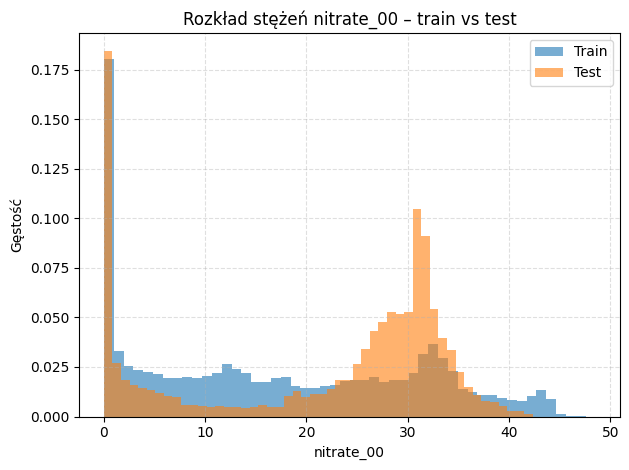

In [19]:
plt.hist(y_train.numpy(), bins=50, alpha=0.6, label='Train', density=True)
plt.hist(y_test, bins=50, alpha=0.6, label='Test', density=True)
plt.legend()
plt.title("Rozkład stężeń nitrate_00 – train vs test")
plt.xlabel("nitrate_00")
plt.ylabel("Gęstość")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

<ipython-input-20-515316e5ddf4>:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


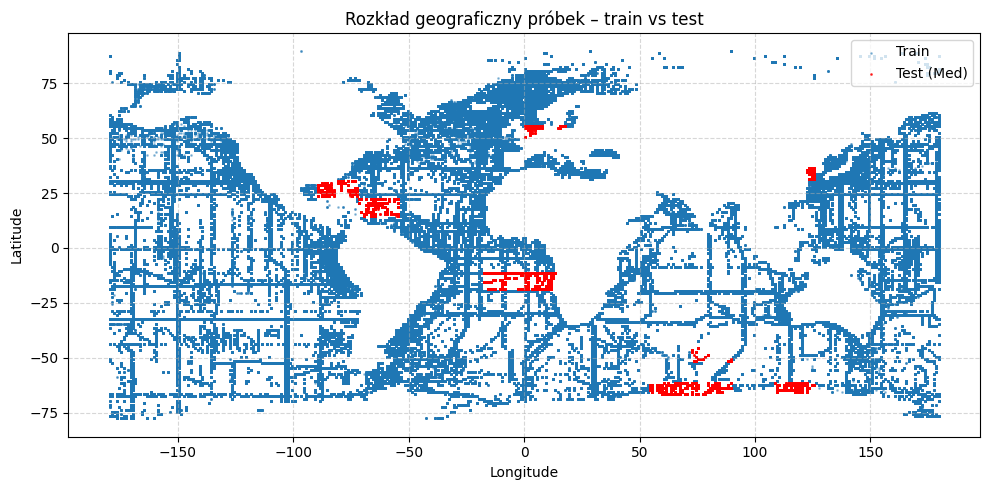

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(df[~test_mask]["lon"], df[~test_mask]["lat"], s=1, label="Train", alpha=0.4)
plt.scatter(df[test_mask]["lon"], df[test_mask]["lat"], s=1, label="Test (Med)", alpha=0.7, color="red")
plt.legend()
plt.title("Rozkład geograficzny próbek – train vs test")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

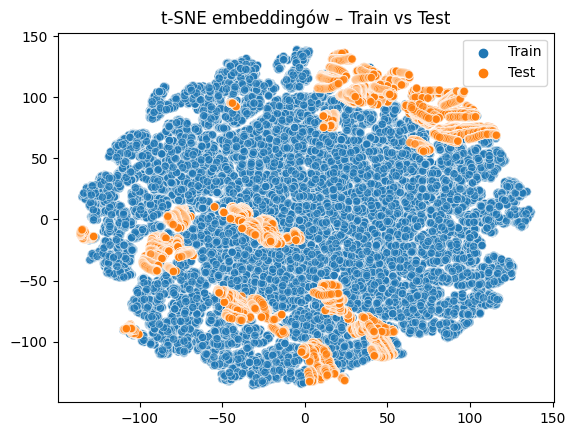

In [ ]:
from sklearn.manifold import TSNE

embeddings_train = model.encoder(X_train.cuda()).detach().cpu().numpy()
embeddings_test  = model.encoder(X_test.cuda()).detach().cpu().numpy()

emb_all = np.vstack([embeddings_train, embeddings_test])
labels  = np.array(["Train"] * len(embeddings_train) + ["Test"] * len(embeddings_test))

emb_2d = TSNE().fit_transform(emb_all)

import seaborn as sns
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, alpha=0.6)
plt.title("t-SNE embeddingów – Train vs Test")
plt.show()

## Training loop

In [21]:
def train(model_, loader_, n_epochs=20, lr=1e-3, weight_decay=1e-4, verbose=True, gradient_clipping=False):
    opt = torch.optim.Adam(model_.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        model_.train()
        total_loss = 0
        all_y = []
        all_pred = []

        for x, y in loader_:
            x, y = x.cuda(), y.cuda()
            pred = model_(x).flatten()

            loss = loss_fn(pred, y)
            loss.backward()

            if gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model_.parameters(), max_norm=1.0)

            opt.step()
            opt.zero_grad()

            total_loss += loss.item()
            all_y.append(y.detach().cpu())
            all_pred.append(pred.detach().cpu())

        scheduler.step()

        # Concatenate all predictions and targets
        all_y = torch.cat(all_y).numpy()
        all_pred = torch.cat(all_pred).numpy()

        r2 = r2_score(all_y, all_pred)
        avg_loss = total_loss / len(loader_)

        if verbose:
            print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}  R2 = {r2:.4f}")

    return avg_loss, r2

def metrics(name, y, pred, verbose=True):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, pred)
    r2   = r2_score(y, pred)
    if verbose:
        print(f"{name:<18} RMSE={rmse:.4f} MSE={mse:.4f} MAE={mae:.4f} R2={r2:.4f}")
    return mse, rmse, mae, r2



def evaluate(name, model_, loader_):
    model_.eval()
    for x, y in loader_:
        x, y = x.cuda(), y.cuda()
        pred = model_(x).flatten()
        y = y.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        return metrics(name, y, pred)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

## Sanity check: linear prediction without embeddings

In [22]:
class BaselineMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.predictor(x).squeeze(-1)

for _ in range(1):
    torch.manual_seed(42); torch.cuda.manual_seed_all(42)
    pred_model = BaselineMLP(in_dim=9).cuda()
    _ = train(pred_model, train_loader, n_epochs=13, lr=1e-3, verbose=False)
    _ = evaluate("Baseline", pred_model, test_loader)

Baseline           RMSE=1.7121 MSE=2.9313 MAE=1.1222 R2=0.9824


## Simple linear prediction

In [29]:
class LinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Linear(in_dim, 1)

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = LinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-3)

Epoch 1: loss = 191.4459  R2 = -0.0403
Epoch 2: loss = 29.1941  R2 = 0.8414
Epoch 3: loss = 15.4331  R2 = 0.9162
Epoch 4: loss = 11.4749  R2 = 0.9377
Epoch 5: loss = 9.4019  R2 = 0.9489
Epoch 6: loss = 8.2752  R2 = 0.9550
Epoch 7: loss = 7.5784  R2 = 0.9588
Epoch 8: loss = 7.0656  R2 = 0.9616
Epoch 9: loss = 6.6556  R2 = 0.9638
Epoch 10: loss = 6.3180  R2 = 0.9657
Epoch 11: loss = 6.0404  R2 = 0.9672
Epoch 12: loss = 5.8116  R2 = 0.9684
Epoch 13: loss = 5.6197  R2 = 0.9695
Epoch 14: loss = 5.4589  R2 = 0.9703
Epoch 15: loss = 5.3268  R2 = 0.9711
Epoch 16: loss = 5.2118  R2 = 0.9717
Epoch 17: loss = 5.1136  R2 = 0.9722
Epoch 18: loss = 5.0299  R2 = 0.9727
Epoch 19: loss = 4.9568  R2 = 0.9731
Epoch 20: loss = 4.8935  R2 = 0.9734
Epoch 21: loss = 4.8378  R2 = 0.9737
Epoch 22: loss = 4.7920  R2 = 0.9740
Epoch 23: loss = 4.7485  R2 = 0.9742
Epoch 24: loss = 4.7100  R2 = 0.9744
Epoch 25: loss = 4.6778  R2 = 0.9746
Epoch 26: loss = 4.6477  R2 = 0.9747
Epoch 27: loss = 4.6230  R2 = 0.9749
Epoc

In [30]:
_ = evaluate("Linear prediction", pred_model, test_loader)

Linear prediction  RMSE=1.9717 MSE=3.8875 MAE=1.3444 R2=0.9767


## Multi-layer linear prediction

In [32]:
class MultiLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
pred_model = MultiLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-3)

Epoch 1: loss = 33.8450  R2 = 0.8161
Epoch 2: loss = 4.4712  R2 = 0.9757
Epoch 3: loss = 3.8943  R2 = 0.9788
Epoch 4: loss = 3.6159  R2 = 0.9804
Epoch 5: loss = 3.4523  R2 = 0.9812
Epoch 6: loss = 3.3448  R2 = 0.9818
Epoch 7: loss = 3.2630  R2 = 0.9823
Epoch 8: loss = 3.1949  R2 = 0.9826
Epoch 9: loss = 3.1470  R2 = 0.9829
Epoch 10: loss = 3.0939  R2 = 0.9832
Epoch 11: loss = 3.0623  R2 = 0.9834
Epoch 12: loss = 3.0118  R2 = 0.9836
Epoch 13: loss = 2.9962  R2 = 0.9837
Epoch 14: loss = 2.9618  R2 = 0.9839
Epoch 15: loss = 2.9323  R2 = 0.9841
Epoch 16: loss = 2.9040  R2 = 0.9842
Epoch 17: loss = 2.8872  R2 = 0.9843
Epoch 18: loss = 2.8604  R2 = 0.9845
Epoch 19: loss = 2.8420  R2 = 0.9846
Epoch 20: loss = 2.8270  R2 = 0.9846
Epoch 21: loss = 2.8045  R2 = 0.9848
Epoch 22: loss = 2.7957  R2 = 0.9848
Epoch 23: loss = 2.7802  R2 = 0.9849
Epoch 24: loss = 2.7622  R2 = 0.9850
Epoch 25: loss = 2.7542  R2 = 0.9850
Epoch 26: loss = 2.7412  R2 = 0.9851
Epoch 27: loss = 2.7311  R2 = 0.9852
Epoch 28:

In [33]:
_ = evaluate("Multi-layer linear prediction", pred_model, test_loader)

Multi-layer linear prediction RMSE=1.6808 MSE=2.8251 MAE=1.0372 R2=0.9831


## Linear+Dropout prediction

In [35]:
class DropoutLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae, dropout=0.3):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),           # Reduced from 0.5 to avoid underfitting
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout / 2),       # Add dropout between deeper layers
            nn.Linear(64, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
pred_model = DropoutLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-3, gradient_clipping=True)

Epoch 1: loss = 18.2947  R2 = 0.9006
Epoch 2: loss = 7.4309  R2 = 0.9596
Epoch 3: loss = 6.9985  R2 = 0.9620
Epoch 4: loss = 6.7886  R2 = 0.9631
Epoch 5: loss = 6.5016  R2 = 0.9647
Epoch 6: loss = 6.2913  R2 = 0.9658
Epoch 7: loss = 6.1277  R2 = 0.9667
Epoch 8: loss = 6.0593  R2 = 0.9671
Epoch 9: loss = 5.8663  R2 = 0.9681
Epoch 10: loss = 5.7747  R2 = 0.9686
Epoch 11: loss = 5.6291  R2 = 0.9694
Epoch 12: loss = 5.5907  R2 = 0.9696
Epoch 13: loss = 5.4607  R2 = 0.9703
Epoch 14: loss = 5.3527  R2 = 0.9709
Epoch 15: loss = 5.3041  R2 = 0.9712
Epoch 16: loss = 5.2449  R2 = 0.9715
Epoch 17: loss = 5.2282  R2 = 0.9716
Epoch 18: loss = 5.1725  R2 = 0.9719
Epoch 19: loss = 5.1228  R2 = 0.9722
Epoch 20: loss = 5.1642  R2 = 0.9719


In [36]:
_ = evaluate("Dropout+linear prediction", pred_model, test_loader)

Dropout+linear prediction RMSE=1.6504 MSE=2.7238 MAE=1.0295 R2=0.9837


## Deeper Droput prediction

In [39]:
class DeepDropoutLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae, dropout=0.3):
        super().__init__()
        self.mae = mae

        # Freeze MAE if needed
        for param in self.mae.parameters():
            param.requires_grad = False

        self.predictor = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.SiLU(),
            nn.Dropout(dropout),

            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(dropout),

            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        enc = self.mae.encoder(x)  # (B, D)
        return self.predictor(enc).squeeze(-1)  # (B,)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
pred_model = DeepDropoutLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=30, lr=1e-3, weight_decay=5e-4, gradient_clipping=True)

Epoch 1: loss = 32.0343  R2 = 0.8259
Epoch 2: loss = 10.9376  R2 = 0.9406
Epoch 3: loss = 9.5838  R2 = 0.9479
Epoch 4: loss = 8.7961  R2 = 0.9522
Epoch 5: loss = 8.3003  R2 = 0.9549
Epoch 6: loss = 7.8315  R2 = 0.9575
Epoch 7: loss = 7.3732  R2 = 0.9599
Epoch 8: loss = 7.0956  R2 = 0.9615
Epoch 9: loss = 6.9230  R2 = 0.9624
Epoch 10: loss = 6.7448  R2 = 0.9634
Epoch 11: loss = 6.6139  R2 = 0.9641
Epoch 12: loss = 6.4763  R2 = 0.9648
Epoch 13: loss = 6.3072  R2 = 0.9657
Epoch 14: loss = 6.2437  R2 = 0.9661
Epoch 15: loss = 6.0895  R2 = 0.9669
Epoch 16: loss = 6.0817  R2 = 0.9670
Epoch 17: loss = 6.0483  R2 = 0.9671
Epoch 18: loss = 5.9564  R2 = 0.9676
Epoch 19: loss = 5.9036  R2 = 0.9679
Epoch 20: loss = 5.8486  R2 = 0.9682
Epoch 21: loss = 5.7940  R2 = 0.9685
Epoch 22: loss = 5.8171  R2 = 0.9684
Epoch 23: loss = 5.7594  R2 = 0.9687
Epoch 24: loss = 5.7151  R2 = 0.9690
Epoch 25: loss = 5.6642  R2 = 0.9692
Epoch 26: loss = 5.6880  R2 = 0.9691
Epoch 27: loss = 5.7108  R2 = 0.9690
Epoch 28

In [40]:
_ = evaluate("Deep dropout+linear prediction", pred_model, test_loader)

Deep dropout+linear prediction RMSE=1.6634 MSE=2.7668 MAE=1.1322 R2=0.9834


## GELU prediction

In [49]:
class GELUPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
pred_model = GELUPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-3)

Epoch 1: loss = 18.8670  R2 = 0.8975
Epoch 2: loss = 6.9362  R2 = 0.9623
Epoch 3: loss = 6.3118  R2 = 0.9657
Epoch 4: loss = 5.8644  R2 = 0.9681
Epoch 5: loss = 5.6694  R2 = 0.9692
Epoch 6: loss = 5.3780  R2 = 0.9708
Epoch 7: loss = 5.1792  R2 = 0.9719
Epoch 8: loss = 4.9817  R2 = 0.9729
Epoch 9: loss = 4.8878  R2 = 0.9734
Epoch 10: loss = 4.7515  R2 = 0.9742
Epoch 11: loss = 4.6552  R2 = 0.9747
Epoch 12: loss = 4.5642  R2 = 0.9752
Epoch 13: loss = 4.4767  R2 = 0.9757
Epoch 14: loss = 4.4477  R2 = 0.9758
Epoch 15: loss = 4.3621  R2 = 0.9763
Epoch 16: loss = 4.3272  R2 = 0.9765
Epoch 17: loss = 4.2895  R2 = 0.9767
Epoch 18: loss = 4.2420  R2 = 0.9770
Epoch 19: loss = 4.2679  R2 = 0.9768
Epoch 20: loss = 4.2169  R2 = 0.9771


In [50]:
_ = evaluate("GELU prediction", pred_model, test_loader)

GELU prediction    RMSE=1.6143 MSE=2.6058 MAE=0.9955 R2=0.9844


## Residual Block prediction

In [45]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
        )
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        return self.ln(x + self.block(x))

class ResidualPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae

        for param in self.mae.parameters():
            param.requires_grad = False

        self.input_proj = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.SiLU()
        )

        self.residual_blocks = nn.Sequential(
            ResidualBlock(256, dropout=0.3),
            ResidualBlock(256, dropout=0.2)
        )

        self.output_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        enc = self.mae.encoder(x)  # (B, D)
        x = self.input_proj(enc)   # (B, 256)
        x = self.residual_blocks(x)
        return self.output_head(x)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
pred_model = ResidualPredictionModel(in_dim=128, mae=model).cuda()
pred_model.input_proj.apply(initialize_weights)
pred_model.output_head.apply(initialize_weights)
pred_model.residual_blocks.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=30, lr=5e-4)

Epoch 1: loss = 14.3682  R2 = 0.9219
Epoch 2: loss = 5.4509  R2 = 0.9704
Epoch 3: loss = 5.1168  R2 = 0.9722
Epoch 4: loss = 4.9691  R2 = 0.9730
Epoch 5: loss = 4.7595  R2 = 0.9741
Epoch 6: loss = 4.6471  R2 = 0.9748
Epoch 7: loss = 4.5227  R2 = 0.9754
Epoch 8: loss = 4.4986  R2 = 0.9756
Epoch 9: loss = 4.3816  R2 = 0.9762
Epoch 10: loss = 4.3229  R2 = 0.9765
Epoch 11: loss = 4.2258  R2 = 0.9770
Epoch 12: loss = 4.1834  R2 = 0.9773
Epoch 13: loss = 4.1059  R2 = 0.9777
Epoch 14: loss = 4.0575  R2 = 0.9780
Epoch 15: loss = 3.9914  R2 = 0.9783
Epoch 16: loss = 3.9642  R2 = 0.9785
Epoch 17: loss = 3.8924  R2 = 0.9789
Epoch 18: loss = 3.8995  R2 = 0.9788
Epoch 19: loss = 3.8492  R2 = 0.9791
Epoch 20: loss = 3.8304  R2 = 0.9792
Epoch 21: loss = 3.8065  R2 = 0.9793
Epoch 22: loss = 3.7197  R2 = 0.9798
Epoch 23: loss = 3.7272  R2 = 0.9798
Epoch 24: loss = 3.7074  R2 = 0.9799
Epoch 25: loss = 3.6870  R2 = 0.9800
Epoch 26: loss = 3.6677  R2 = 0.9801
Epoch 27: loss = 3.6521  R2 = 0.9802
Epoch 28:

In [46]:
_ = evaluate("Residual prediction", pred_model, test_loader)

Residual prediction RMSE=1.5528 MSE=2.4113 MAE=0.9394 R2=0.9856


In [47]:
torch.manual_seed(42); torch.cuda.manual_seed_all(42)
model= MaskedAutoEncoder(in_dim=9, maskable_dim=4, depth=4, embed_dim=128)
pred_model = ResidualPredictionModel(in_dim=128, mae=model).cuda()
pred_model.input_proj.apply(initialize_weights)
pred_model.output_head.apply(initialize_weights)
pred_model.residual_blocks.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-4)
_ = evaluate("Residual prediction", pred_model, test_loader)

Epoch 1: loss = 37.8985  R2 = 0.7941
Epoch 2: loss = 6.5769  R2 = 0.9643
Epoch 3: loss = 5.8307  R2 = 0.9683
Epoch 4: loss = 5.4915  R2 = 0.9702
Epoch 5: loss = 5.2731  R2 = 0.9714
Epoch 6: loss = 5.1225  R2 = 0.9722
Epoch 7: loss = 4.9779  R2 = 0.9730
Epoch 8: loss = 4.9289  R2 = 0.9732
Epoch 9: loss = 4.7904  R2 = 0.9740
Epoch 10: loss = 4.7593  R2 = 0.9741
Epoch 11: loss = 4.6843  R2 = 0.9746
Epoch 12: loss = 4.6465  R2 = 0.9748
Epoch 13: loss = 4.5700  R2 = 0.9752
Epoch 14: loss = 4.5410  R2 = 0.9753
Epoch 15: loss = 4.4676  R2 = 0.9757
Epoch 16: loss = 4.4419  R2 = 0.9759
Epoch 17: loss = 4.3835  R2 = 0.9762
Epoch 18: loss = 4.4018  R2 = 0.9761
Epoch 19: loss = 4.3431  R2 = 0.9764
Epoch 20: loss = 4.3439  R2 = 0.9764
Epoch 21: loss = 4.3055  R2 = 0.9766
Epoch 22: loss = 4.2213  R2 = 0.9771
Epoch 23: loss = 4.2431  R2 = 0.9769
Epoch 24: loss = 4.2279  R2 = 0.9770
Epoch 25: loss = 4.1974  R2 = 0.9772
Epoch 26: loss = 4.1893  R2 = 0.9772
Epoch 27: loss = 4.1633  R2 = 0.9774
Epoch 28: